In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
from scipy.stats import multivariate_normal as N

In [68]:
data = pd.read_csv('./data/old_faithful.csv', index_col=0)
data = data / data.max(axis=0)

In [970]:
class GMM(object):
    def __init__(self, n_components):
        self.m = n_components
        self.dim = None
        self.Pi = [0.5] * n_components
        self.comps = []
        self.centers = None
        self.sigmas = None
    
    def fit(self, data, max_iter=1, stop_thresh=1e-4):
        dim = data.shape[1]
        self.sigmas = [np.eye(dim)] * self.m
        self.centers = np.random.permutation(data)[:self.m]
        self._new_comp(self.centers, self.sigmas)

        for i in range(max_iter):
            if self.step(data) < stop_thresh:
                print(f"finished early on step {i}")
                break
    
    def _new_comp(self, mu, sigma):
        for i, s in enumerate(sigma):
            if np.linalg.det(s) < 1e-6:
                sigma[i] = np.eye(s.shape[0]) * 0.01
                
        self.comps = [
            N(c, sigm).pdf for (c, sigm) in zip(mu, sigma)
        ]
        delta = max([np.linalg.norm(c-cp) for c,cp in zip(mu, self.centers)])
        self.centers = mu
        self.sigmas = sigma
        return delta
    
    def step(self, data):
        gamma = self._E(data)
        mu, sigma = self._M(data, gamma)
        return self._new_comp(mu, sigma)
        
    def _E(self, data):
        resp = np.c_[[Pi * c(data) for Pi,c in zip(self.Pi, self.comps)]].T
        norms = resp.sum(axis=1)
        return resp / norms[:,np.newaxis]
    
    def _M(self, data, gammas):
        Nk = gammas.sum(axis=0)
        mu_n = [1/Nk[i] * (data * gammas[:,i:i+1]).sum(axis=0) for i in range(self.m)]
        t = lambda i: gammas[:,i:i+1]*(data - mu_n[i])
        sigm_n = [t(i).T @ t(i) / Nk[i] for i in range(self.m)]
        self.Pi = Nk / len(data)
        return mu_n, sigm_n

In [971]:
def plot_gauss(mu, sigma, c='r'):
    lam, v = np.linalg.eig(sigma)
    lam = np.sqrt(lam)
    ell = Ellipsex(y=mu, width=lam[0]*2, height=lam[1]*2,
                  angle=np.rad2deg(np.arccos(v[0, 0]))
                 )
    ell.set_facecolor(c)
    ell.set_edgecolor('w')
    ell.set_alpha(0.5)
    return ell

In [1031]:
gmm = GMM(3)

In [1032]:
gmm.fit(data, max_iter=500)

finished early on step 88


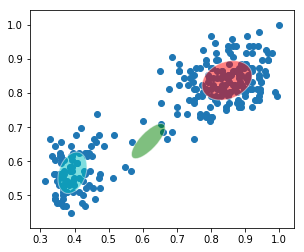

In [1033]:
ax = plt.subplot(111, aspect='equal')
for mu,sigm,c in zip(gmm.centers, gmm.sigmas, ['r','g','c']):
    ell = plot_gauss(mu, sigm, c)
    ax.add_artist(ell)
plt.scatter(data[:,0], data[:,1])